# Default Template

In [1]:
import os
import sys
import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import muon as mu
mu.set_options(pull_on_update=False)

import scanpy as sc

2025-09-06 17:29:14.618060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 17:29:14.671692: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-06 17:29:17.892903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
sys.path.insert(0, '/scratch/g/tgu/svenkatesan/Other/SCREAM_wf')
import SCREAM

In [3]:
mainDir = '/scratch/g/tgu/svenkatesan/Other/SCREAM_wf'
inputDir = os.path.join(mainDir, 'inputfiles')
rawDir = os.path.join(inputDir, 'raw')
processedDir = os.path.join(inputDir, 'processed')
resultsDir = os.path.join(mainDir, 'results')

In [4]:
print(f'Time before running script: {datetime.datetime.now().strftime("%d %b %Y %H:%M:%S")}')  # datetime object

Time before running script: 06 Sep 2025 17:29:19


## Main script

In [5]:
mdata = mu.read_h5mu(os.path.join(processedDir, 'scream_cellline_atac.h5mu'))
display(mdata)

MuData object with n_obs × n_vars = 1047 × 7636
  obs:	'desc_0.1', 'desc_0.2', 'desc_0.3', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9', 'desc_1.0', 'desc_0.05'
  uns:	'desc_0.1_colors', 'prob_matrix0.05', 'prob_matrix0.1', 'prob_matrix0.2', 'prob_matrix0.3', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8', 'prob_matrix0.9', 'prob_matrix1.0', 'tsne', 'umap'
  obsm:	'X_Embedded_z0.05', 'X_Embedded_z0.1', 'X_Embedded_z0.2', 'X_Embedded_z0.3', 'X_Embedded_z0.4', 'X_Embedded_z0.5', 'X_Embedded_z0.6', 'X_Embedded_z0.7', 'X_Embedded_z0.8', 'X_Embedded_z0.9', 'X_Embedded_z1.0', 'X_tsne', 'X_tsne0.05', 'X_tsne0.1', 'X_tsne0.2', 'X_tsne0.3', 'X_tsne0.4', 'X_tsne0.5', 'X_tsne0.6', 'X_tsne0.7', 'X_tsne0.8', 'X_tsne0.9', 'X_tsne1.0', 'X_umap', 'X_umap0.05', 'X_umap0.1', 'X_umap0.2', 'X_umap0.3', 'X_umap0.4', 'X_umap0.5', 'X_umap0.6', 'X_umap0.7', 'X_umap0.8', 'X_umap0.9', 'X_umap1.0', 'joint_ls'
  2 modalities
    RNA:	1047 x 500
      obs:	'cell_line'
      uns:	'desc_ls_hparams'
      obsm:	'X_desc_ls'
    ATAC:	1047 x 7136
      obs:	'cell_line'
      uns:	'desc_ls_hparams'
      obsm:	'X_desc_ls'

In [7]:
leiden_res = sorted(set(list(np.linspace(0.1, 1, num=10).round(decimals=2))).
                    union(set([0.05])))

{}


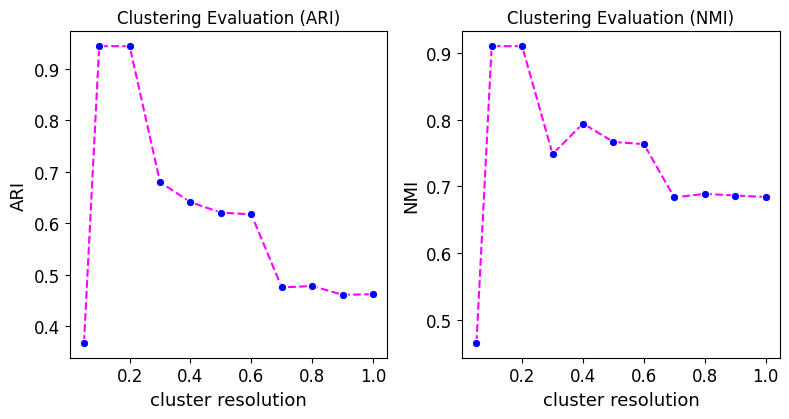

In [9]:
ari_pd = SCREAM.models.tools.calc_ari(mdata, label_col='RNA:cell_line', cluster_res=leiden_res)
nmi_pd = SCREAM.models.tools.calc_nmi(mdata, label_col='RNA:cell_line', cluster_res=leiden_res)

metrics_df = ari_pd.join([nmi_pd])
fig = SCREAM.models.tools.plot_clustereval(metrics_df, res_col='cluster resolution', met_cols=None, ncols=5, figsize=None)

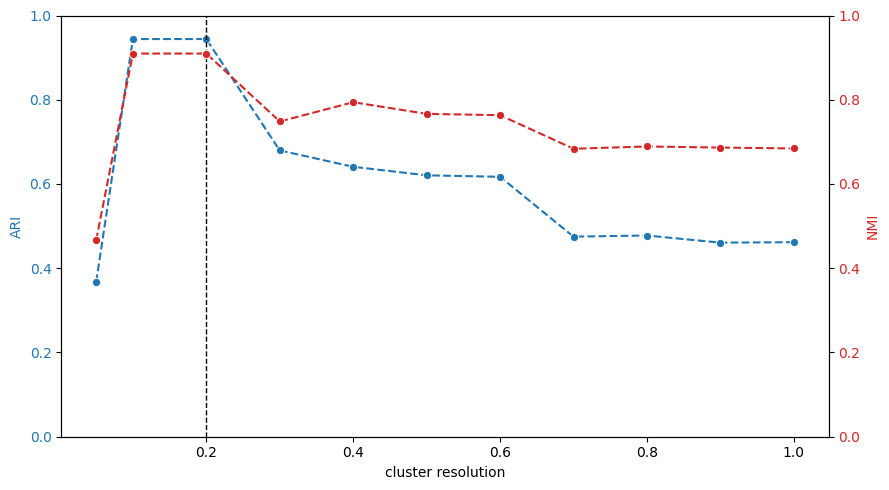

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 5), layout='tight')
ax2 = ax1.twinx()

default_plot_opts = {'marker': 'o', 'linestyle': '--'}

# plot first metric
sns.lineplot(data=metrics_df, x='cluster resolution', y='ARI', ax=ax1, color='tab:blue', **default_plot_opts)
ax1.set_ylabel('ARI', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1)
# plot second metric
sns.lineplot(data=metrics_df, x='cluster resolution', y='NMI', ax=ax2, color='tab:red', **default_plot_opts)
ax2.set_ylabel('NMI', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 1)
ax1.set_xlabel('cluster resolution')

ax1.axvline(x=0.2, color='k', linestyle='--', linewidth=1)
# ax1.axvline(x=1.75, color='k', linestyle='--', linewidth=1)
# fig.tight_layout()
# return fig

fig.savefig(os.path.join(processedDir, 'celline_metrics_plot.png'), dpi=300, bbox_inches='tight')

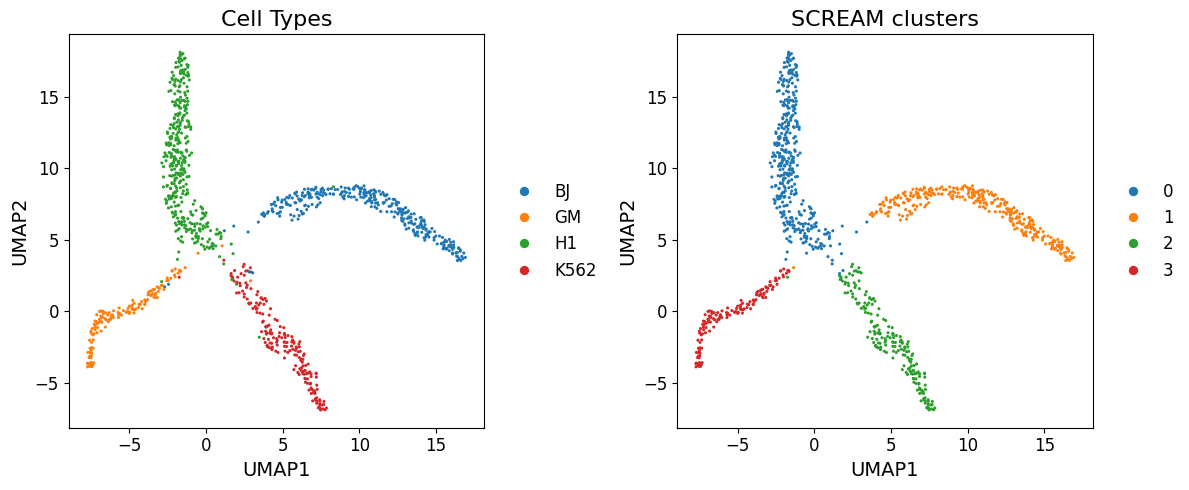

In [34]:
plot_df = pd.DataFrame(mdata.obsm['X_umap0.2'], columns=['UMAP1', 'UMAP2'], index=mdata.obs_names)
plot_df['cell_line'] = mdata.mod['RNA'].obs['cell_line'].values
plot_df['desc_0.2'] = mdata.obs['desc_0.2'].values  # assuming this lives in .obs of mdata

# plot with seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5), layout='tight')
ax = ax.ravel()
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2',
                hue='cell_line', s=5, ax=ax[0], linewidth=0)
ax[0].set_title('Cell Types', fontsize=16)
ax[0].set_xlabel('UMAP1', fontsize=14)
ax[0].set_ylabel('UMAP2', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2',
                hue='desc_0.2', s=5, ax=ax[1], linewidth=0)
ax[1].set_title('SCREAM clusters', fontsize=16)
ax[1].set_xlabel('UMAP1', fontsize=14)
ax[1].set_ylabel('UMAP2', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

for a in ax:
    legend = a.get_legend()
    handles, labels = a.get_legend_handles_labels()
    a.legend(handles, labels,
             loc='center left',
             bbox_to_anchor=(1.02, 0.5),
             frameon=False,        # no box
             markerscale=3,        # bigger circles in legend
             fontsize=12,
             title=None)

fig.savefig(os.path.join(processedDir, 'celline_umaps_plot.png'), dpi=300, bbox_inches='tight')

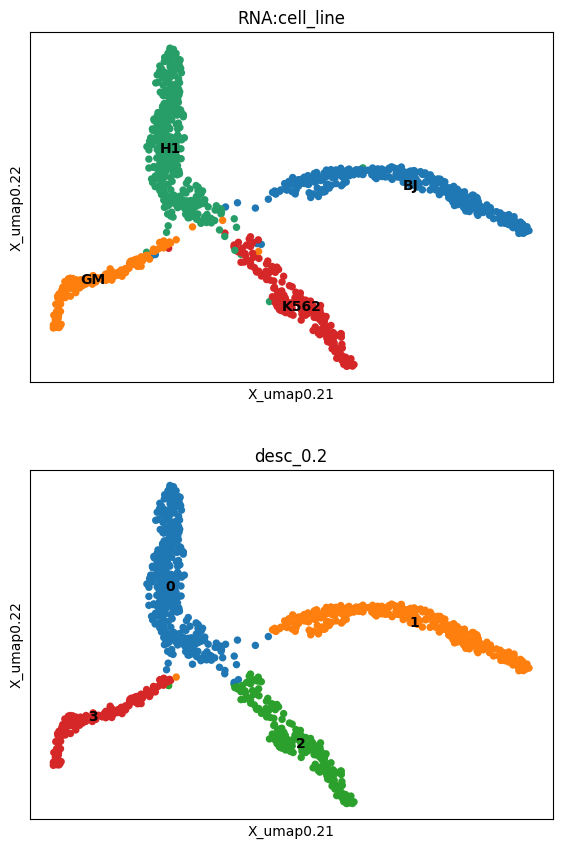

In [29]:
fig = mu.pl.embedding(mdata, color=['RNA:cell_line', 'desc_0.2'], basis='X_umap0.2', ncols=2, legend_loc='on data', show=False, return_fig=True)
fig.savefig(os.path.join(processedDir, 'celline_umaps_plot2.png'), dpi=300, bbox_inches='tight')

In [59]:
moclust_ari = pd.read_csv(os.path.join(rawDir, 'Moclust_plots', 'ARI cellline.csv')).rename(columns={'y': 'ARI'})
moclust_nmi = pd.read_csv(os.path.join(rawDir, 'Moclust_plots', 'NMI cellline.csv')).rename(columns={'y': 'NMI'})
moclust_metrics = pd.concat([moclust_ari, moclust_nmi], axis=1)
moclust_metrics.index = ['cobolt', 'DCCA', 'Harmony', 'Liger', 'Moclust',
                         'MOFA+', 'MultiVI', 'scAI', 'scMVAE', 'Seurat', 'UnionCom']

In [60]:
full_metrics = pd.concat([metrics_df.loc[0.2, :].to_frame().T, moclust_metrics], axis=0).rename(index={0.2: 'SCREAM'})

In [61]:
full_metrics 

,ARI,NMI
SCREAM,0.944107,0.909666
cobolt,0.643450,0.785790
DCCA,0.791370,0.821580
Harmony,0.125730,0.315870
Liger,0.120800,0.303420
Moclust,0.829580,0.890040
MOFA+,0.698920,0.751560
MultiVI,0.809860,0.778010
scAI,0.509090,0.533710
scMVAE,0.714950,0.779560


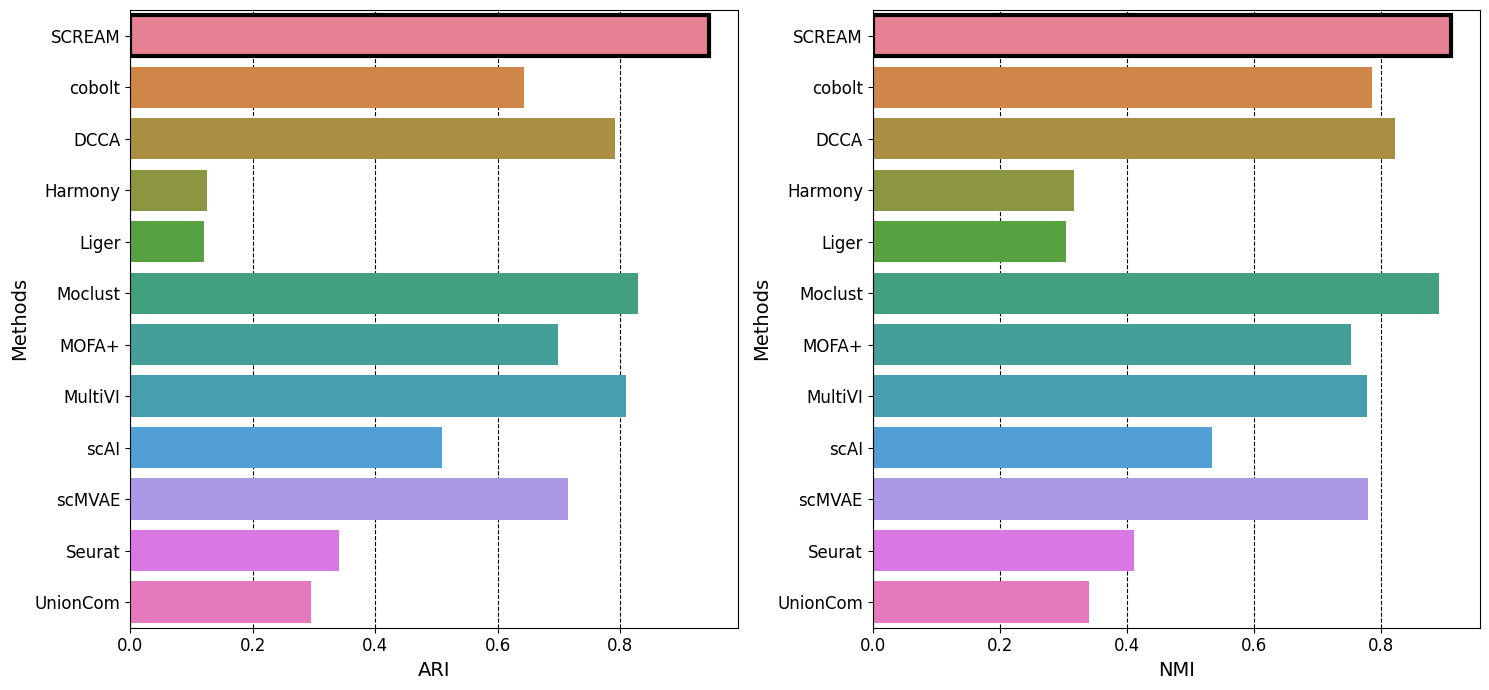

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), layout='tight')
ax = ax.ravel()
sns.barplot(full_metrics.reset_index(names='Methods'), y='Methods', x='ARI', ax=ax[0], hue='Methods', legend=False, zorder=2)
ax[0].set_xlabel('ARI', fontsize=14)
ax[0].set_ylabel('Methods', fontsize=14)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].xaxis.grid(True, which='major', linestyle='--', linewidth=0.8, color='black')

sns.barplot(full_metrics.reset_index(names='Methods'), y='Methods', x='NMI', ax=ax[1], hue='Methods', legend=False, zorder=2)
ax[1].set_xlabel('NMI', fontsize=14)
ax[1].set_ylabel('Methods', fontsize=14)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].xaxis.grid(True, which='major', linestyle='--', linewidth=0.8, color='black')

bars0 = ax[0].patches
last_bar0 = bars0[0]
last_bar0.set_edgecolor('black')
last_bar0.set_linewidth(3)

# highlight last bar in NMI plot
bars1 = ax[1].patches
last_bar1 = bars1[0]
last_bar1.set_edgecolor('black')
last_bar1.set_linewidth(3)

fig.savefig(os.path.join(processedDir, 'celline_comparisons_plot.png'), dpi=300, bbox_inches='tight')

## Script summary

In [ ]:
print(f'Time after running script: {datetime.datetime.now().strftime("%d %b %Y %H:%M:%S")}')  # datetime object

In [ ]:
import session_info
try:
    print(session_info.show(cpu=True, dependencies=True, html=False))
except Exception:
    print(session_info.show(cpu=True, dependencies=False, html=False))